# Dinkey Creek
 
#### Project description 
##### This notebook is a collection of my work related to the Dinkey Creek watershed landscape, in support of Joint Fire Science Program funded research. The project aims to assess the impacts of various management practices related to fire suppression and mechanical thinning ecosystem function. We are using the LANDIS model to simulate forest growth and management across the landscape, with fire tossed into the mix. Much of the initial parameterization of the landscape was conduced by Shuang et al., 2015 as part of a larger regional look at the Sierra National Forest as a whole. However, given the disparity in geographic extent between the entire Sierra and the Dinkey Creek watershed, the majority of modeling prep work required to turn the LANDIS crank had to be redone. For the time being, species paramterization however is still untouched (save the addition of a couple species and several modifications to the functional group descriptions in Shuang et al., 2015). 

#### Specific changes
* Ecoregion designation
    * Establishment of climatic and edaphic variability
    
* Addition of shrubs
    * Species and functional group paramterization -- may need to update for Century extension 4.0
    * Modification of mapunit FIA imputations to accomodate shrubs
    
* Grabbing appropriate climate data
    * Select and force climate data to play nice with the new LANDIS climate library v1.0
    
* Calibrating and paramterizing Century extension 4.0
    * Do what you can with GSSURGO and STASGO data to find informed ecoregion params
    * For the time being, assess FIA above ground biomass, stratified by ecoregion
    * Compare FIA biomass data to Jenkins allometrics as a gut check
    * Use AGB as a proxy for success when analyzing LANDIS output under a range of non-informed ecoregion params


In [225]:
# Specify inline plots for notebook
%matplotlib inline
from matplotlib.font_manager import FontProperties

# Libraries -- overkill for the time being
import statsmodels.api as sm
import matplotlib.pyplot as plt
from lxml import etree
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
import pandas as pd
import seaborn as sns
import numpy as np
import os, datetime
from osgeo import gdal
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates 

# Set working dir
wrkDir = 'C:/Research/Dinkey_Creek/GIS_Data_And_Maps/'


### Ecoregion Creation
#### The Dinkey Creek landsacpe is characterized by an elevation gradient, increasing along a southwest to northeast transect over ~300 - 3000 meters (Fig 1). Initially, we split the landscape into five elevation bins, which roughly corresponded with broad patterns in precipitation and temperature trends across the watershed. 

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


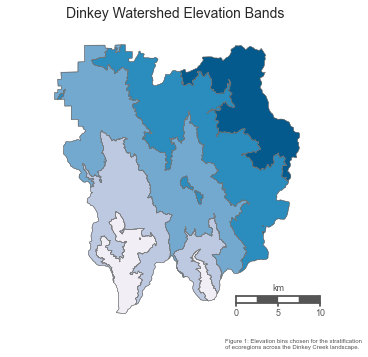

In [2]:
shp = fiona.open(wrkDir + 'DinkeyElevationShp.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

fig1 = plt.figure(figsize = (6,6))
ax = fig1.add_subplot(111, frameon = False)

m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'DinkeyElevationShp', 'Elevation',
    color='grey',
    zorder=2)

# set up a map dataframe
elev = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.Elevation]})
for shape in enumerate(df_map['poly']):
    keys, values = m.Elevation_info[shape[0]].keys(),m.Elevation_info[shape[0]].values()
    elev.append(values[1])
df_map['Elevation'] = elev
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
elevFC = ['#f1eef6','#bdc9e1','#74a9cf','#2b8cbe','#045a8d']
idx = 0 # Colormap iterator
for feature in np.unique(df_map.Elevation):
    ax.add_collection(PatchCollection(df_map.patches[df_map.Elevation == feature], facecolor= elevFC[idx]))
    idx = idx + 1
ax.set_title('Dinkey Watershed Elevation Bands', fontsize = 14)
smallprint = ax.text(
    .65, 0,
    '''Figure 1: Elevation bins chosen for the stratification
of ecoregions across the Dinkey Creek landscape.''',
    size=6,
    color='#555555',
    transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.3, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.show()

#### We used GSSURGO data to bin the landscape by soil parent material (Figure 2), which roughly tracked soil and clay content, and consequently water holding capacity. We then generated ecoregions given the stratification of elevation and soil groups (Figure 3), such that within each ecoregion, soil and climate characteristics are reasonably homogeneous. Nine distinct parent material groups were lumped into three related bins to simplify the landscape (Table 1). 

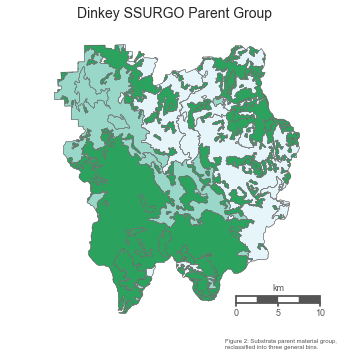

Table 1: The attribute table for the GSSURGO vector data that we used to define coregions
described nine distinct groups. In an effort to represent the edaphic gradient acros the Dinkey
Watershed, we binned these parent material groups into three categories (Figure 2)


In [3]:
shp = fiona.open(wrkDir + 'DinkeyGSSURGODissolveNAD83.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

fig2 = plt.figure(figsize = (6,6))
ax = fig2.add_subplot(111, frameon = False)

m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'DinkeyGSSURGODissolveNAD83', 'PGroup',
    color='grey',
    zorder=2)

# set up a map dataframe
parentgroup = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.PGroup]})
for shape in enumerate(df_map['poly']):
    keys, values = m.PGroup_info[shape[0]].keys(),m.PGroup_info[shape[0]].values()
    parentgroup.append(values[3])
df_map['ParentGroup'] = parentgroup
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
ParentGFC = ['#e5f5f9','#99d8c9','#2ca25f']
idx = 0 # Colormap iterator
for feature in np.unique(df_map.ParentGroup):
    ax.add_collection(PatchCollection(df_map.patches[df_map.ParentGroup == feature], facecolor= ParentGFC[idx]))
    idx = idx + 1
ax.set_title('Dinkey SSURGO Parent Group', fontsize = 14)
smallprint = ax.text(
    .65, 0,
    '''Figure 2: Substrate parent material group,
reclassified into three general bins.''',
    size=6,
    color='#555555',
    transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.3, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.show()

# Display a table of the GSSURGO parent material binning for transparency
gssurgo_bins = pd.read_csv(wrkDir + 'GSSURGO_Dissolve.txt', sep = ',')
gssurgo_bins
print '''Table 1: The attribute table for the GSSURGO vector data that we used to define coregions
described nine distinct groups. In an effort to represent the edaphic gradient acros the Dinkey
Watershed, we binned these parent material groups into three categories (Figure 2)'''

#### We overlayed the three substrate bins and five elevation bands to generate the eight Landis-II ecoregions (Figure 3)

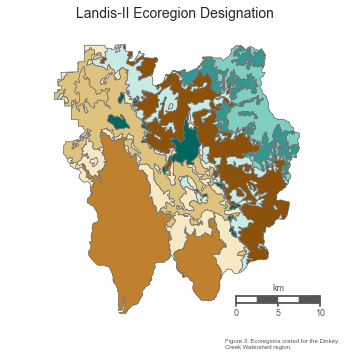

In [4]:
shp = fiona.open(wrkDir + 'EcoregionsNAD83.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

fig3 = plt.figure(figsize = (6,6))
ax = fig3.add_subplot(111, frameon = False)

m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'EcoregionsNAD83', 'Ecoregion',
    color='grey',
    zorder=2)

# set up a map dataframe
ecoregion = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.Ecoregion]})
for shape in enumerate(df_map['poly']):
    keys, values = m.Ecoregion_info[shape[0]].keys(),m.Ecoregion_info[shape[0]].values()
    ecoregion.append(values[5])
df_map['Ecoregion'] = ecoregion
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
EcoregionFC = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
               '#c7eae5', '#80cdc1','#35978f', '#01665e']

idx = 0 # Colormap iterator
for feature in np.unique(df_map.Ecoregion):
    ax.add_collection(PatchCollection(df_map.patches[df_map.Ecoregion == feature], facecolor= EcoregionFC[idx]))
    idx = idx + 1
ax.set_title('Landis-II Ecoregion Designation', fontsize = 14)
smallprint = ax.text(
    .65, 0,
    '''Figure 3: Ecoregions crated for the Dinkey,
Creek Watershed region.''',
    size=6,
    color='#555555',
    transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.3, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.show()

#### Ecoregion wilting point, field cap, SOM and N values


In [5]:
# Moving through the century ecoregion paramterization lists, sand and clay were 
# quickly gleaned using zonal stats by ecoregion on the mean values for GSSURGO
# sand and clay (representative values). 

# Wilting point and field capacity were calculated from soil texture data (SSURGO)
# Using the following ref:
# K.E. Saxton et al., 1986 
# Estimating generalized soil-water characteristics from texture. 
# Soil Sci. Soc. Amer. J. 
# 50(4):1031-1036

# Initial organic matter and nitrogen values, as well as N and OM decay rates 
# were taken from Shuang et al., (temporary) as ballpark placeholders. 


### Adding shrubs to the landscape
#### The initial communities file prepared for Shuang et al., 2015 (?) does not contain any shrub species. We wanted to add two species,  Ceanothus cordulatus and Arctostaphylos patula, to the landscape. To do so, we simple added a functional group (shrub), and the two species paramterizations (from Loudermilk et al., 2013) to the century extension files. The only code for this task had to do with editing the initial communities text file.

In [6]:
# Ref for species paramterization:

# "Loudermilk, E. Louise, et al. "Carbon dynamics in the future forest: 
# the importance of long‐term successional legacy and climate–fire interactions.
# "Global change biology 19.11 (2013): 3502-3515."

# The task here is to add species cohorts to every map unit. The idea being that shrubs
# should have a chance to capitalize on fire wherever it happens, and the cost
# of adding them across the landscape is minimal given their negligible biomass.

# Read in and edit an existing text file ---
ic_filename = 'C:/Research/Dinkey_Creek/ic_dinkey.txt'
new_ic_filename = 'C:/Research/Dinkey_Creek/ic_dinkey_shrubs.txt'
with open(ic_filename) as f_old, open(new_ic_filename, "w") as f_new:
    for line in f_old:
        f_new.write(line)
        if 'MapCode' in line:
            f_new.write("whitethorn 10 20\n")
            f_new.write("greenleaf 10 20\n")

### Climate Data Selection and Summary
#### We chose to use Daymet Daily surface weather over a 1km grid for the study: doi:10.3334/ORNLDAAC/1219, as acquired via the USGS Geo Data Portal (http://cida.usgs.gov/gdp/). Weighted area grid statistics were computed by the export service on a per-ecoregion basis.

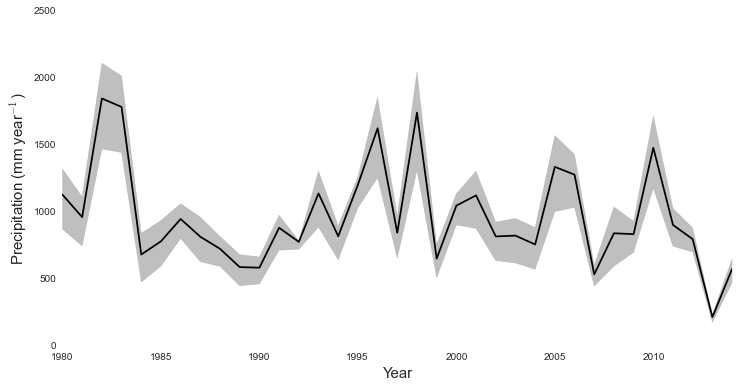

In [7]:
# Placeholder for plots of climate data by ecoregion
climdata = pd.read_csv('C:/Research/Dinkey_Creek/DinkeyClimate_PrecipMeans.csv')

climdata['TS'] = pd.to_datetime(climdata.TIMESTEP)
climdata.index = climdata.TS
recentclim = climdata[climdata.index.year > 1950]

fig4 = plt.figure(figsize = (12,6))
ax = fig4.add_subplot(111, frameon = False)
    
pcpAnnual = recentclim.groupby([recentclim.index.year]).sum()
#for ecoregion in np.arange(0,7):
    #pcpAnnual[[ecoregion]].plot(ax = ax, color = 'gray', alpha = 0.4)
pcpAnnual.mean(axis = 1).plot(ax = ax, color = 'black')
pcpAnnual['Year'] = pcpAnnual.index
plt.fill_between(pcpAnnual.Year, pcpAnnual['MEAN B'], pcpAnnual['MEAN F'],
                 interpolate=True,color='grey', alpha = 0.5)
ax.set_ylabel('Precipitation (mm year$^{-1}$)', fontsize = 15)
ax.set_xlabel('Year', fontsize = 15)

In [8]:
climdataF = pd.read_csv('C:/Research/Dinkey_Creek/DinkeyClimate_Daymet_Formatted_P.csv')
climdataF['TS'] = pd.to_datetime(climdataF.TIMESTEP)
climdataF.index = climdataF.TS

climdataF.groupby([climdataF.index.year, climdataF.index.month]).sum()
monthlyClimData = pd.DataFrame()
for column in np.arange(0,8):
    monthlyClimData[[column]] = climdataF[[column+1]].groupby([climdataF[[column+1]].index.year, 
                                                             climdataF[[column+1]].index.month]).sum()
for column in np.arange(9,16):
    monthlyClimData[[column]] = climdataF[[column-8]].groupby([climdataF[[column-8]].index.year, 
                                                             climdataF[[column-8]].index.month]).var()


### Century Calibration
#### First on the list is to check the post-spinup species biomass compared to FIA plot data. This probably needs to happen on a per-ecoregion basis first, using only species and cohorts represented by a specific FIA plot.

In [9]:
# Load in the FIA data, which is a mess of sheets that need to be related to one another.
FIA_Dir = 'C:/Research/Dinkey_Creek/FIA_Data/'

# Two sheets used here, the plot data which contains Lat and Lon coordinates (CA_PLOT)
# and a subset of CA_COND which I made in excel, filtering out only the forest types 
# which occurr within the Dinkey Creek watershed.
allPlotData = pd.read_csv(FIA_Dir + 'CA_Plot.csv')
someForTypes = pd.read_csv(FIA_Dir + 'Plot2ForType.csv')

# The business end of the plots sheet is CA_TREE.csv, which contains one record for each
# individual measured in each plot. 
allTrees = pd.read_csv(FIA_Dir + 'CA_TREE.csv')

# Apparently the only way to reference a single plot between sheets, is to combine
# the inventory year (INVYR), the state, unit, and county codes (STATECD, UNITCD, COUNTYCD),
# as well as the plot (PLOT). Apparently however, the metadata is incorrect. By adding the CONDID
# column as well, we finally can get unique plot IDs.
allPlotData['PLOT_ID'] = (allPlotData.INVYR.astype(str) + allPlotData.STATECD.astype(str) +
                          allPlotData.UNITCD.astype(str)+ allPlotData.COUNTYCD.astype(str) + 
                          allPlotData.PLOT.astype(str))

someForTypes['PLOT_ID'] = (someForTypes.INVYR.astype(str) + someForTypes.STATECD.astype(str) +
                           someForTypes.UNITCD.astype(str)+ someForTypes.COUNTYCD.astype(str) + 
                           someForTypes.PLOT.astype(str))

allTrees['PLOT_ID'] = (allTrees.INVYR.astype(str) + allTrees.STATECD.astype(str) +
                       allTrees.UNITCD.astype(str)+ allTrees.COUNTYCD.astype(str) + 
                       allTrees.PLOT.astype(str))

# Restrict the plots used by some rough bounding boxes (Lat and Lon)
plotsubset = allPlotData[allPlotData.PLOT_ID.isin(someForTypes.PLOT_ID)]
plotsubsetLL = plotsubset[(plotsubset.LAT > 36.9) & 
                           (plotsubset.LAT < 38) & 
                           (plotsubset.LON > -119.8) & 
                           (plotsubset.LON < -118.0)]


# Restrict the plots used by some rough bounding boxes (Lat and Lon)
# Here we impose very strict latlong cutoffs based on the extent of our Dinkey Creek polygon.
# This results in very few (~30) plots being used.
plotsubsetLL_dink = plotsubset[(plotsubset.LAT > 36) & 
                           (plotsubset.LAT < 37.16) & 
                           (plotsubset.LON > -119.26) & 
                           (plotsubset.LON < -119.028)]

toUseFIA = someForTypes[someForTypes.PLOT_ID.isin(plotsubsetLL.PLOT_ID)]
toUseFIA_Dink = someForTypes[someForTypes.PLOT_ID.isin(plotsubsetLL_dink.PLOT_ID)]

# Experimenting with a plot level basal live area cutoff to screen out plots with unusually low biomass
toUseFIA_Dink = toUseFIA_Dink[toUseFIA_Dink.BALIVE > 50]
toUseFIA = toUseFIA[toUseFIA.BALIVE > 50]

toUseTREES = allTrees[allTrees.PLOT_ID.isin(toUseFIA.PLOT_ID)]
toUseTREES_Dink = allTrees[allTrees.PLOT_ID.isin(toUseFIA_Dink.PLOT_ID)]

# Find out what forest type codes are extracted, and pull their info just to know what I'm dealing with
#np.unique(toUseFIA.FORTYPCD)

# 261 -- White Fir: Associates – Douglas-fir, sugar pine, ponderosa pine, Jeffrey pine, incense-cedar,
#California red fir, blue spruce, limber pine, and aspen

#371 -- California Mixed Conifer: Associates - a complex association of ponderosa pine, sugar pine,
#Douglas-fir, white fir, red fir, and incense-cedar. Generally, five or six conifer species are intermixed
#either as single trees or in small groups.

#924 -- Blue Oak: Associates - Gray pine, interior live oak, canyon live oak, valley oak, and California
#buckeye

#934 -- Interior live oak: Associates - Blue oak, coast live oak, valley oak, canyon live oak, gray pine,
#ponderosa pine, Douglas-fir.



C:\Anaconda\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [10]:
# Strategy for computing a per plot biomass estimate is to loop through each plot which came out of the 
# subsetting process above, and within it sum up the above ground tree biomass (CARBON_AG) field for the 
# plot. Also calculate the variance for each plot, and create a new dataframe which consists of the forest type,
# AGB, and AGB_var.
biomass = []
biomassVar = []
plotnum = []
forestType = []
lat = []
lon = []
# Generate per plot biomass dataframe -- stratified by forest type
for thisplot in np.unique(toUseTREES.PLOT_ID):
    if len(toUseFIA[toUseFIA.PLOT_ID == thisplot]) == 1:
        plotnum.append(thisplot)
        biomass.append(toUseTREES[toUseTREES.PLOT_ID == thisplot].CARBON_AG.sum())
        biomassVar.append(toUseTREES[toUseTREES.PLOT_ID == thisplot].CARBON_AG.std())
        forestType.append(np.unique(toUseFIA[toUseFIA.PLOT_ID == thisplot].FORTYPCD))
        lat.append(np.unique(plotsubsetLL[plotsubsetLL.PLOT_ID == thisplot].LAT))
PlotTotalBiomass = pd.DataFrame(dict(PlotNum = plotnum, Lat = lat, ForestType = forestType, 
                                     Biomass = biomass, BiomassVar = biomassVar))
PlotTotalBiomass.ForestType = PlotTotalBiomass.ForestType.astype(int)

# Create a similar data frame, but for individual species codes
biomass = []
biomassVar = []
speciesCode = []
forestType = []
lat = []
lon = []
# Generate per plot biomass dataframe -- stratified by forest type
for thisSpecies in np.unique(toUseTREES.SPCD):
    speciesCode.append(thisSpecies)
    biomass.append(toUseTREES[toUseTREES.SPCD == thisSpecies].CARBON_AG.sum())
    biomassVar.append(toUseTREES[toUseTREES.SPCD == thisSpecies].CARBON_AG.std())
SpeceistTotalBiomass = pd.DataFrame(dict(SpeciesCode = speciesCode, Biomass = biomass, 
                                         BiomassVar = biomassVar))


In [11]:
# Jenkins allometry lookup table -- Each unique FIA species code present in the DinkeyCreek watershed
# FIA plots is listed below, and lumped into the corresponding Species Group (Jenkins et al., 2003). 
# The following code then draws the corresponding allometric equation
# parameters from Jenkins et al., 2003 -- Table 1, and computes total aboveground biomass from the FIA
# reported DBH.

# np.unique(toUseTREES.SPCD)

Pines = [101, 104, 108, 113, 116, 117, 119, 122, 127, 133]
TrueFirs = [14, 15, 20, 251, 264]
DougFir = [202]
Woodland = [50, 64, 299, 475, 997]
Cedar = [81,212]
MixedHardwoods = [333, 492, 730, 768, 981]
AspenAlder = [352, 746, 747]
MapleOak = [805, 807, 815, 818, 821, 839]

    

In [12]:
# This block of code produces some indexing warnings... don't have time to figure it out
# right now, so I suppress them
import warnings
warnings.filterwarnings('ignore')

pines = toUseTREES.SPCD.isin(Pines)
trueFirs = toUseTREES.SPCD.isin(TrueFirs)
dougFir = toUseTREES.SPCD.isin(DougFir)
woodland = toUseTREES.SPCD.isin(Woodland)
cedar = toUseTREES.SPCD.isin(Cedar)
mixedHardwoods = toUseTREES.SPCD.isin(MixedHardwoods)
aspenAlder = toUseTREES.SPCD.isin(AspenAlder)
mapleOak = toUseTREES.SPCD.isin(MapleOak)
toUseTREES['spcgrp'] = 'na'
toUseTREES['jenkinsBio'] = 0

toUseTREES.spcgrp[pines] = 'pines'
toUseTREES.spcgrp[trueFirs] = 'trueFirs'
toUseTREES.spcgrp[dougFir] = 'dougFir'
toUseTREES.spcgrp[woodland] = 'woodland'
toUseTREES.spcgrp[cedar] = 'cedar'
toUseTREES.spcgrp[mixedHardwoods] = 'mixedHardwoods'
toUseTREES.spcgrp[aspenAlder] = 'aspenAlder'
toUseTREES.spcgrp[mapleOak] = 'mapleOak'
#np.unique(toUseTREES.spcgrp)

jenkinsParams = pd.DataFrame(dict(speciesGroup = ['pines', 'trueFirs', 'dougFir', 
                                                  'woodland', 'cedar', 'mixedHardwoods',
                                                  'aspenAlder', 'mapleOak'],
                                  b0 = [-2.5356, -2.5384, -2.2304,  -0.7152,
                                        -2.0336, -2.4800, -2.2094, -2.0127],
                                  b1 = [2.4349, 2.4814, 2.4435, 1.7029, 2.2592,
                                       2.4835, 2.3867, 2.4342]))

for group in jenkinsParams.speciesGroup:
    print group
    grpsub = jenkinsParams[jenkinsParams.speciesGroup == group]
    b0 = float(grpsub.b0)
    b1 = float(grpsub.b1)

    biomass = np.exp(b0 + b1*np.log(toUseTREES[toUseTREES.spcgrp == group].DIA*2.54))
    toUseTREES.jenkinsBio[toUseTREES.spcgrp == group] = biomass

# Sum the above ground biomass fields from the FIA data, and convert the pounds
# to kilograms
toUseTREES['totalBio'] = ((toUseTREES.DRYBIO_BOLE + toUseTREES.DRYBIO_TOP + \
                         toUseTREES.DRYBIO_STUMP + toUseTREES.DRYBIO_WDLD_SPP.fillna(0) +
                         toUseTREES.DRYBIO_SAPLING.fillna(0)) * 0.453592) 

# Each tree in the FIA data must be multiplied by an expansion factor (TPA_UNADJ) in
# order to scale the biomass estimates to the plot. Here we also choose to express the
# biomass from FIA (pounds) in grams: 1 pound = 453.592 grams.
# Finally we divide our grams per acre by 1 acre = 4046.86 square meters
# and end up with grams total above ground biomass per square meter. Some inconsistencies
# still exist however, as the FIA data accounts for live and dead biomass, etc.
toUseTREES['totalBio_peracre'] = ((toUseTREES.DRYBIO_BOLE + toUseTREES.DRYBIO_TOP + \
                         toUseTREES.DRYBIO_STUMP + toUseTREES.DRYBIO_WDLD_SPP.fillna(0) +
                         toUseTREES.DRYBIO_SAPLING.fillna(0)) * 453.592) * toUseTREES.TPA_UNADJ / 4046.86

# Repeat the steps for only Dinkey FIA plot trees.
toUseTREES_Dink['totalBio_peracre'] = (((toUseTREES_Dink.DRYBIO_BOLE + toUseTREES_Dink.DRYBIO_TOP + \
                         toUseTREES_Dink.DRYBIO_STUMP + toUseTREES_Dink.DRYBIO_WDLD_SPP.fillna(0) +
                         toUseTREES_Dink.DRYBIO_SAPLING.fillna(0))) * \
                                       toUseTREES_Dink.TPA_UNADJ) / 4046.86 * 453.592

# Undoing the warning suppression from above
warnings.filterwarnings('default')

pines
trueFirs
dougFir
woodland
cedar
mixedHardwoods
aspenAlder
mapleOak


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             jenkinsBio   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                 2.983e+04
Date:                Thu, 19 Nov 2015   Prob (F-statistic):               0.00
Time:                        08:04:05   Log-Likelihood:                -52637.
No. Observations:                5948   AIC:                         1.053e+05
Df Residuals:                    5947   BIC:                         1.053e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
totalBio       1.2131      0.007    172.727      0.000         1.199     1.227
==============================================================================
Omnibus:                     4896.434   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           274555.857
Skew:                           3.557   Prob(JB):                         0.00
Kurtosis:                      35.515   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

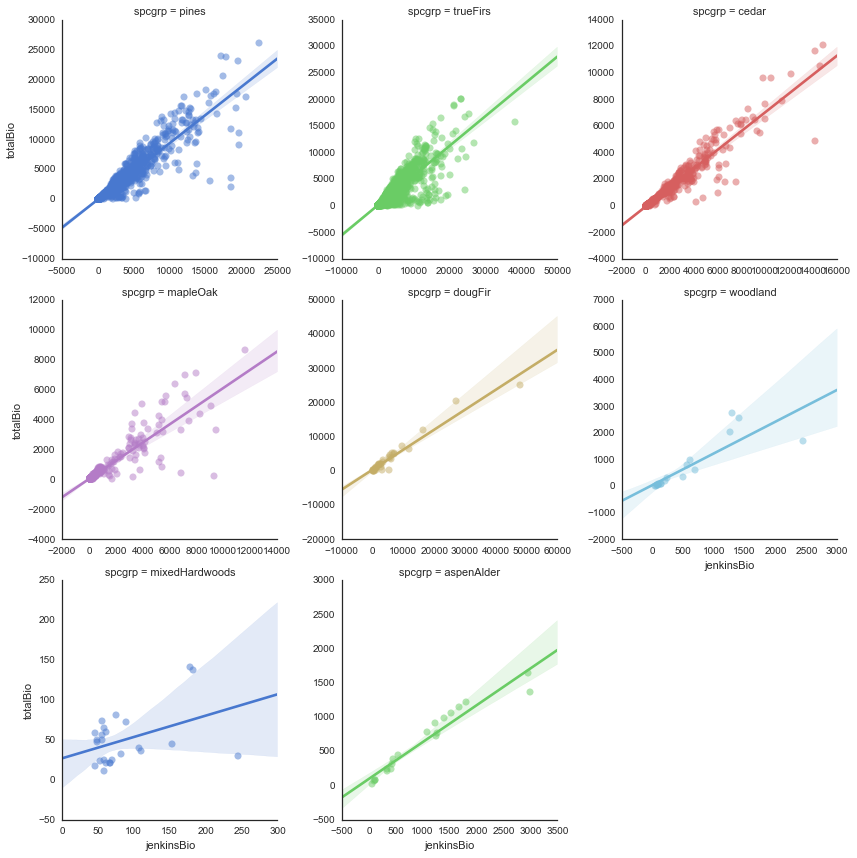

In [13]:
# Interested in some quick statistics comparing the FIA biomass to the Jenkins biomass
# one to one scatterplots of biomass by jenkins 2003 species group below:
sns.set_style('white')
lm = sns.lmplot(x="jenkinsBio", y="totalBio", col="spcgrp", hue="spcgrp", data=toUseTREES,
           col_wrap=3, palette="muted", size=4,
           scatter_kws={"s": 50, "alpha": 0.5}, sharex=False,sharey=False)

# Total biomass fit statistics
mod = sm.OLS(toUseTREES.jenkinsBio, toUseTREES.totalBio, missing='drop')
res = mod.fit()
res.summary()

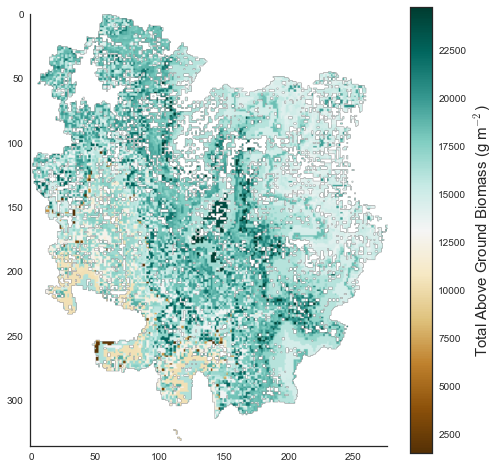

In [17]:
warnings.filterwarnings('ignore')
toUseTREES['adjustedBio'] = toUseTREES['totalBio'] / 4046.86 * 1000

biomap = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ECOREGION_PARAM/param_set_4/output/DinkeyScenario/replicate1/bioMAP/bio-TotalBiomass-0.img'
biomap20 = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ECOREGION_PARAM/Added20yrCohort/replicate1/bioMAP/bio-TotalBiomass-0.img'

biolist = [biomap, biomap20]
t0 = []
t1 = []
outputvar = [t0, t1]
idx = 0
for agbmap in biolist:
    src_ds = gdal.Open( agbmap )
    bioarray = src_ds.ReadAsArray()
    bioarray = bioarray.astype('float')
    bioarray[bioarray == 0] = np.nan
    masked_bio = np.ma.array (bioarray, mask=(np.isnan(bioarray)))
    outputvar[idx] = bioarray
    idx = idx + 1
    
sns.set_style('white')
plt.figure(figsize = (8,8))
plt.imshow(bioarray, cmap = 'BrBG')
sns.despine()
axx = plt.colorbar()
axx.set_label('Total Above Ground Biomass (g m$^{-2}$)', fontsize = 15)
bioarray = outputvar[0]
bioarray20 = outputvar[1]

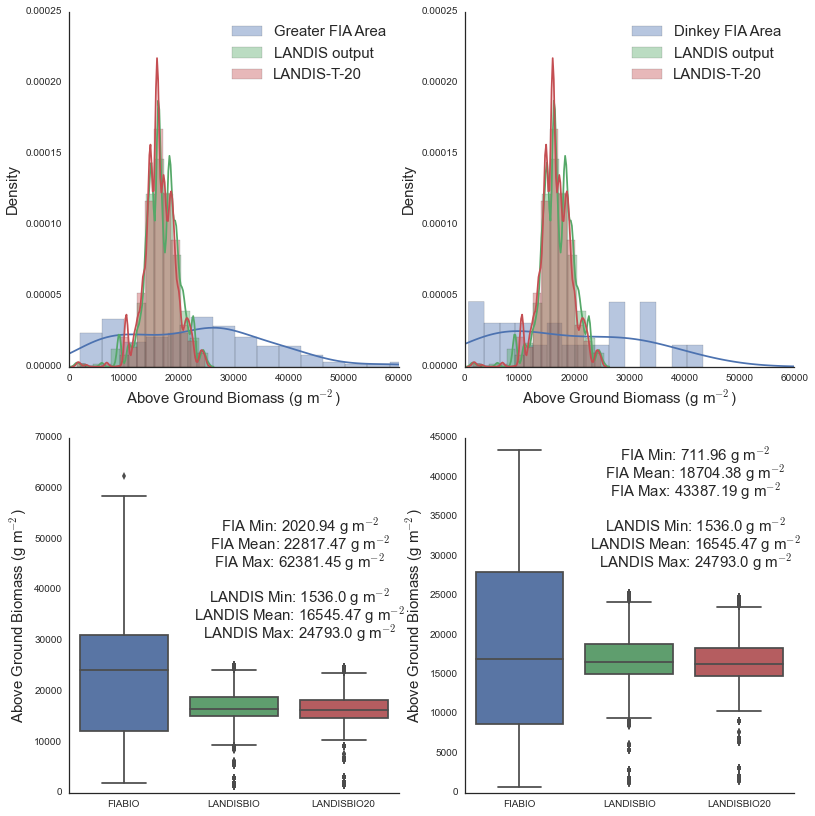

In [18]:
landis_bio = bioarray.ravel()
landis_bio20 = bioarray20.ravel()

fia_bio = toUseTREES.groupby('PLOT_ID').totalBio_peracre.sum().ravel()
fia_bio_dink = toUseTREES_Dink.groupby('PLOT_ID').totalBio_peracre.sum().ravel()

t1 = pd.DataFrame(dict(FIABIO = fia_bio, SOURCE = 'FIA'))
t1D = pd.DataFrame(dict(FIABIO = fia_bio_dink, SOURCE = 'LANDIS'))

t2 = pd.DataFrame(dict(LANDISBIO = landis_bio, LANDISBIO20 = landis_bio20, SOURCE = 'LANDIS'))

check = pd.concat([t1,t2],axis=0, ignore_index=True)
check_Dink = pd.concat([t1D,t2],axis=0, ignore_index=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(13,14))
sns.distplot(check.FIABIO.dropna(), bins = 15, ax = ax1)
sns.distplot(check.LANDISBIO.dropna(), bins = 15, ax = ax1)
sns.distplot(check.LANDISBIO20.dropna(), bins = 15, ax = ax1)

ax1.set_xlim([0,60000])
ax1.set_xlabel('Above Ground Biomass (g m$^{-2}$)', fontsize = 15)
ax1.set_ylabel('Density', fontsize = 15)
ax1.legend(['Greater FIA Area','LANDIS output','LANDIS-T-20'], fontsize = 15)
sns.despine(ax = ax1)

sns.distplot(check_Dink.FIABIO.dropna(), bins = 15, ax = ax2)
sns.distplot(check_Dink.LANDISBIO.dropna(), bins = 15, ax = ax2)
sns.distplot(check_Dink.LANDISBIO20.dropna(), bins = 15, ax = ax2)

ax2.set_xlim([0,60000])
ax2.set_xlabel('Above Ground Biomass (g m$^{-2}$)', fontsize = 15)
ax2.set_ylabel('Density', fontsize = 15)
ax2.legend(['Dinkey FIA Area','LANDIS output','LANDIS-T-20'], fontsize = 15)
sns.despine(ax = ax2)


sns.boxplot(check, ax = ax3)
sns.despine(ax = ax3)
fia_meantext =  'FIA Mean: ' + str(round(np.mean(check.FIABIO.dropna()),2)) + ' g m$^{-2}$'
landis_meantext =  'LANDIS Mean: ' + str(round(np.mean(check.LANDISBIO20.dropna()),2)) + ' g m$^{-2}$'
fia_mintext =  'FIA Min: ' + str(round(np.min(check.FIABIO.dropna()),2)) + ' g m$^{-2}$'
landis_mintext =  'LANDIS Min: ' + str(round(np.min(check.LANDISBIO20.dropna()),2)) + ' g m$^{-2}$'
fia_maxtext =  'FIA Max: ' + str(round(np.max(check.FIABIO.dropna()),2)) + ' g m$^{-2}$'
landis_maxtext =  'LANDIS Max: ' + str(round(np.max(check.LANDISBIO20.dropna()),2)) + ' g m$^{-2}$'

ax3.text(0.7, 0.75,fia_mintext , ha='center', va='center', 
         transform=ax3.transAxes, fontsize = 15)
ax3.text(0.7, 0.7,fia_meantext , ha='center', va='center', 
         transform=ax3.transAxes, fontsize = 15)
ax3.text(0.7, 0.65,fia_maxtext , ha='center', va='center', 
         transform=ax3.transAxes, fontsize = 15)

ax3.text(0.7, 0.55,landis_mintext , ha='center', va='center', 
         transform=ax3.transAxes, fontsize = 15)
ax3.text(0.7, 0.5,landis_meantext , ha='center', va='center', 
         transform=ax3.transAxes, fontsize = 15)
ax3.text(0.7, 0.45,landis_maxtext , ha='center', va='center', 
         transform=ax3.transAxes, fontsize = 15)

ax3.set_ylabel('Above Ground Biomass (g m$^{-2}$)', fontsize = 15)


sns.boxplot(check_Dink, ax = ax4)
sns.despine(ax = ax4)
fia_meantext =  'FIA Mean: ' + str(round(np.mean(check_Dink.FIABIO.dropna()),2)) + ' g m$^{-2}$'
landis_meantext =  'LANDIS Mean: ' + str(round(np.mean(check_Dink.LANDISBIO20.dropna()),2)) + ' g m$^{-2}$'
fia_mintext =  'FIA Min: ' + str(round(np.min(check_Dink.FIABIO.dropna()),2)) + ' g m$^{-2}$'
landis_mintext =  'LANDIS Min: ' + str(round(np.min(check_Dink.LANDISBIO20.dropna()),2)) + ' g m$^{-2}$'
fia_maxtext =  'FIA Max: ' + str(round(np.max(check_Dink.FIABIO.dropna()),2)) + ' g m$^{-2}$'
landis_maxtext =  'LANDIS Max: ' + str(round(np.max(check_Dink.LANDISBIO20.dropna()),2)) + ' g m$^{-2}$'

ax4.text(0.7, 0.95,fia_mintext , ha='center', va='center', 
         transform=ax4.transAxes, fontsize = 15)
ax4.text(0.7, 0.9,fia_meantext , ha='center', va='center', 
         transform=ax4.transAxes, fontsize = 15)
ax4.text(0.7, 0.85,fia_maxtext , ha='center', va='center', 
         transform=ax4.transAxes, fontsize = 15)

ax4.text(0.7, 0.75,landis_mintext , ha='center', va='center', 
         transform=ax4.transAxes, fontsize = 15)
ax4.text(0.7, 0.7,landis_meantext , ha='center', va='center', 
         transform=ax4.transAxes, fontsize = 15)
ax4.text(0.7, 0.65,landis_maxtext , ha='center', va='center', 
         transform=ax4.transAxes, fontsize = 15)

ax4.set_ylabel('Above Ground Biomass (g m$^{-2}$)', fontsize = 15)
plt.savefig('biodistributions.tif')

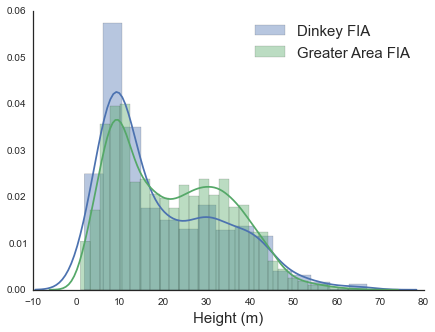

In [19]:
# Curious about the distributions of tree height between the Dinkey FIA plots and the 
# surrounding area FIA plots. More small trees are present in the Dinkey watershed plots
# relative to the surrounding area.

fig, (ax) = plt.subplots(1,1, figsize=(7,5))
sns.distplot(toUseTREES_Dink.HT*0.3048, ax = ax)
sns.distplot(toUseTREES.HT*0.3048, ax = ax)
ax.legend(['Dinkey FIA','Greater Area FIA'], fontsize=15)
ax.set_xlabel('Height (m)', fontsize=15)
sns.despine(ax = ax)

### Ageing the landscape to better match FIA data
#### Based on the plots above comparing FIA and LANDIS data, the median value of plots within the Dinkey Creek watershed best matched after 20 years post spin-up. That being said, we considered the option that our oldest cohorts across the landscape might need to be aged a bit to better match reality. My first approach was to add an additional cohort to the landscape, with an age of max_cohort_age + 20.

#### An additional challenge is that by adding an older cohort across the board, we run into the problem where sometimes we add a 'dead' cohort, because we violated the species longevity parameters. So we need to add a check and balance system. The most plastic way to do this is to read in the species file as a dataframe, and check each addition based on species name.

In [20]:
ic_filename = 'C:/Research/Dinkey_Creek/ic_dinkey_shrubs.txt'
new_ic_filename = 'C:/Research/Dinkey_Creek/ic_dinkey_shrubs_aged.txt'
speciesFile = 'C:/Research/Dinkey_Creek/DinkeySpecies.txt'
species = pd.read_csv(speciesFile, sep = '\t',skiprows = 4, header = None)
speciesList = species[0]
longevity = species[1]
checklist = pd.DataFrame(dict(species = speciesList, ages = longevity))

def group_by_heading( some_source ):
    buffer= []
    for line in some_source:
        if line.startswith( ">>" ):
            if buffer: yield buffer
            buffer= [ line, next(some_source) ]
        else:
            buffer.append( line )
    yield buffer

with open( ic_filename, "r" ) as source:
    with open(new_ic_filename, 'w') as dest:
        for heading_and_lines in group_by_heading( source ):
            heading= heading_and_lines[:2]
            lines= heading_and_lines[2:]
            for line in heading:
                dest.write(line)
            for cohort in np.arange(0,(len(lines))):
                # Write previous spaces for the sake of clarity
                if lines[cohort].startswith((' ', '\n')):
                    dest.write(lines[cohort])
                else:
                    numCohorts = len(lines[cohort].split()) - 1
                    oldestCohort = lines[cohort].split()[numCohorts]
                    cohortSpecies = lines[cohort].split()[0]
                    newOldestCohort = int(oldestCohort) + 20
                    # Make sure the new older cohort is below the maximum cohort age for the species
                    if newOldestCohort <= int(checklist[checklist.species == cohortSpecies].ages):
                        templine = lines[cohort] + ' ' + str(newOldestCohort)
                        finishedLine = templine.replace("\n", "") + '\n'
                        dest.write(finishedLine)
                    # Otherwise write the old cohort back into the new file
                    else:
                        dest.write(lines[cohort])


### Burning the landscape
#### To simulate fire and fire propagation across the watershed, we chose to use the dynamic fire and fuels extensions in LANDIS. The spatial inputs for the extensions were clipped from Shuang et al., 2015, and are described below

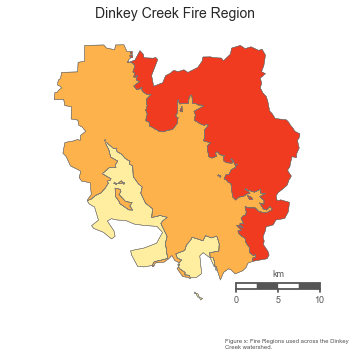

In [21]:
shp = fiona.open(wrkDir + 'DinkeyFireRegions_ll.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

fig3 = plt.figure(figsize = (6,6))
ax = fig3.add_subplot(111, frameon = False)

m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'DinkeyFireRegions_ll', 'FireRegion',
    color='grey',
    zorder=2)

# set up a map dataframe
fireregion = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.FireRegion]})
for shape in enumerate(df_map['poly']):
    keys, values = m.FireRegion_info[shape[0]].keys(),m.FireRegion_info[shape[0]].values()
    fireregion.append(values[3])
df_map['FireRegion'] = fireregion
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
EcoregionFC = ['#ffeda0', '#feb24c', '#f03b20']

idx = 0 # Colormap iterator
for feature in np.unique(df_map.FireRegion):
    ax.add_collection(PatchCollection(df_map.patches[df_map.FireRegion == feature], facecolor= EcoregionFC[idx]))
    idx = idx + 1
ax.set_title('Dinkey Creek Fire Region', fontsize = 14)
smallprint = ax.text(
    .65, 0,
    '''Figure x: Fire Regions used across the Dinkey
Creek watershed.''',
    size=6,
    color='#555555',
    transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.3, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.show()

#### Describing the distribution of fire frequency and size across the Dinkey region. We chose a larger representative area from which to generate the distribution.

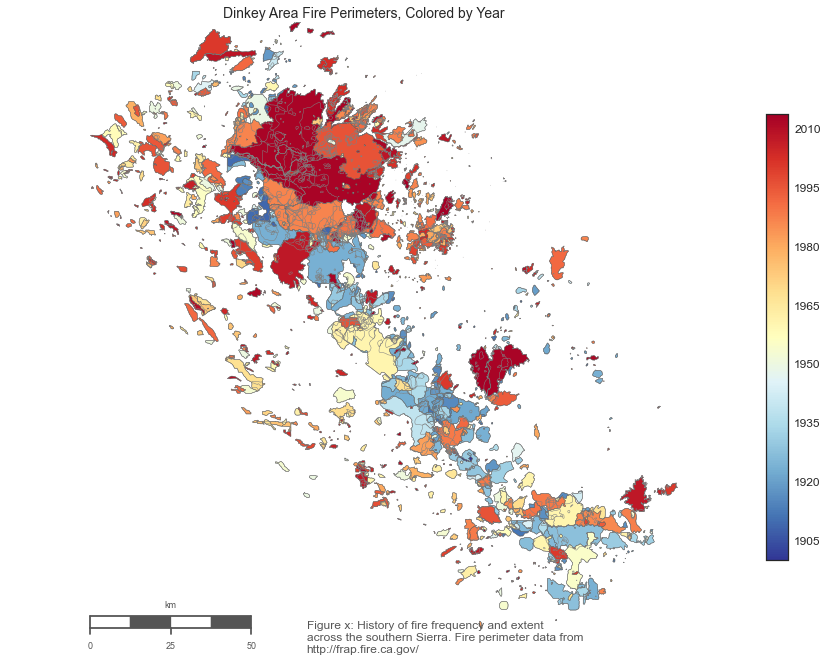

Range of colorbar is :1900 to 2014


In [22]:
shp = fiona.open(wrkDir + 'DinkeyAreaFires_ll2.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

fig3 = plt.figure(figsize = (16,16))
ax = fig3.add_subplot(111, frameon = False)

m = Basemap(llcrnrlon=-121,llcrnrlat=36.5,urcrnrlon=-118.5,urcrnrlat=38.26,
             resolution='i', projection='aea', lat_0 = 37.62, lon_0 = -119.51)
    
m.readshapefile(wrkDir + 'DinkeyAreaFires_ll2', 'FireRegion',
    color='grey',
    zorder=2)

# set up a map dataframe
fireregion = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.FireRegion]})
for shape in enumerate(df_map['poly']):
    keys, values = m.FireRegion_info[shape[0]].keys(),m.FireRegion_info[shape[0]].values()
    fireregion.append(values[2])
df_map['FireRegion'] = fireregion
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

fireregion = map(int, fireregion)
#for feature in np.unique(df_map.FireRegion):
p = PatchCollection(df_map.patches,cmap=plt.get_cmap('RdYlBu_r'))
p.set_array(np.array(fireregion))
p.set_clim([np.ma.min(fireregion),np.ma.max(fireregion)])
cbar = plt.colorbar(p, shrink = 0.5)
cbar.ax.tick_params(labelsize=12) 

ax.add_collection(p)
ax.set_title('Dinkey Area Fire Perimeters, Colored by Year', fontsize = 14)
smallprint = ax.text(
    .42, 0,
    '''Figure x: History of fire frequency and extent
across the southern Sierra. Fire perimeter data from
http://frap.fire.ca.gov/''',
    size=12,
    color='#555555',
    transform=ax.transAxes)
# Draw a map scale
m.drawmapscale(
    coords[0] + 0.3, coords[1] + 0.015,
    coords[0], coords[1],
    50.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.show()
print "Range of colorbar is :%s to %s"%(np.ma.min(fireregion),np.ma.max(fireregion))

In [ ]:
from scipy import stats
# Derive the mu and sigma params from CALFIRE data directly
# in LANDIS-II DFFS, mu and sigma are the location of mean and sd
# of the lognormal distributions -- therefore, we can do two things... 
# either take the mean of the natural log of the data, or fit a lognormal
# distribution to the log transformed data.

# Data driven approach:
metadata['HECTARES'] = metadata.GIS_ACRES * 0.404686
firesizeMu = np.log(metadata.HECTARES).mean()
firesizeSd = np.log(metadata.HECTARES).std()

# Modeled approach:
# Limit fires to those > 1 ha
metadata.HECTARES[metadata.HECTARES < 1] = np.nan
firesize = np.log(metadata.HECTARES).dropna()
rvs = firesize # Generate some random variates as data
n, bins, patches = plt.hist(rvs, bins=25, normed=True) # Plot histogram

shape, loc, scale = stats.lognorm.fit(rvs, floc=0) # Fit a curve to the variates
mu = np.log(scale) # Mean of log(X)
sigma = shape # Standard deviation of log(X)
M = np.exp(mu) # Geometric mean == median
s = np.exp(sigma) # Geometric standard deviation

# Plot figure of results
x = np.linspace(rvs.min(), rvs.max(), num=400)
plt.plot(x, stats.lognorm.pdf(x, shape, loc=0, scale=scale), 'r', linewidth=3) # Plot fitted curve
ax = plt.gca() # Get axis handle for text positioning
txt = plt.text(0.9, 0.9, 'M = %.2f\ns = %.2f' % (M, s), horizontalalignment='right', 
                size='large', verticalalignment='top', transform=ax.transAxes)
print "scatter for data is %s when modeled and %s from data" %(s, firesizeSd)
print "mean of data is %s when modeled and %s from data" %(M, firesizeMu)  
print "maximum fire size from the data in hectares: %s" %metadata.HECTARES.max()

### Looking at some of the output from the LANDIS runs with and without fire, with varying degrees of ProbabilityOfEstablishment

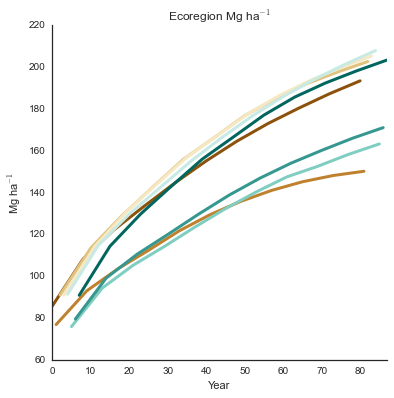

In [26]:
century_succession = pd.read_csv('Z:/Dan K/DinkeyCreek/LANDIS_RUNS/FireP_est1/output/DinkeyScenario/replicate1/Century-succession-log.csv')
century_monthly = pd.read_csv('Z:/Dan K/DinkeyCreek/LANDIS_RUNS/FireP_est1/output/DinkeyScenario/replicate1/Century-succession-monthly-log.csv')
DFFSlog = pd.read_csv('Z:/Dan K/DinkeyCreek/LANDIS_RUNS/FireP_est1/output/DinkeyScenario/replicate1/dynamic-fire-test-log.csv')
groupedCentury = century_succession.groupby(['EcoregionName', 'Time']).mean()

EcoregionFC = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
               '#c7eae5', '#80cdc1','#35978f', '#01665e']

fig = plt.figure(figsize = (6,6))
idx = 0
for ecoregion in np.unique(century_succession.EcoregionName):
    eco = century_succession[century_succession.EcoregionName == ecoregion]
    ecoAGB = eco.AGB / 100 / 2 # Convert gram / m2 to Mg / ha -- then AGB to AGB (c)
    ecoAGB.plot(color = EcoregionFC[idx], lw = 3)
    idx = idx + 1
plt.title('Ecoregion Mg ha$^{-1}$')
plt.xlabel('Year')
plt.ylabel('Mg ha$^{-1}$')
sns.despine()



### PDF Generating plotting function for all time series data in the century output

In [340]:
from matplotlib.backends.backend_pdf import PdfPages
def plotCenturyOutput(inputDir, centFile, monthlyCentFile, simname, rep):
    cent = pd.read_csv(inputDir + centFile)
    centM = pd.read_csv(inputDir + monthlyCentFile)

    # Static vars for now, given that the century output is fairly regular
    centM_vars = ['ppt','airtemp','avgNPPtc','avgResp','avgNEE','Ndep','StreamN']
    cent_vars = cent.columns[4:59]

    pp = PdfPages(simname + '_centuryOut.pdf')
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize =(7, 11))
    axs = f.axes
    idxx = 0
    for var in cent_vars:
        idx = 0
        for eco in np.unique(cent.EcoregionName):
            ax = axs[idxx]
            toplot = cent[cent.EcoregionName == eco]
            index = pd.date_range('2000-1-1', periods=len(toplot), freq='A')
            toplot.index = index
            toplot[var].plot(color=EcoregionFC[idx], marker='o',
                           ax = ax)
            idx = idx + 1
        ax.set_title(var)


        idxx = idxx + 1
        if idxx > 5:
            pp.savefig()
            plt.close();
            f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize =(7, 11))
            axs = f.axes
            idxx = 0
    plt.close();
    pp.close()

    pp = PdfPages(simname + '_centuryOut_Monthly.pdf')
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize =(13, 10))
    axs = f.axes
    idxx = 0
    for var in centM_vars:
        idx = 0
        for eco in np.unique(centM.EcoregionName):
            ax = axs[idxx]
            toplot = centM[centM.EcoregionName == eco]
            index = pd.date_range('2000-1-1', periods=len(toplot), freq='M')
            toplot.index = index
            toplot[var].plot(color=EcoregionFC[idx],
                           ax = ax)
            idx = idx + 1 
        ax.set_title(var)


        idxx = idxx + 1
        if idxx > 3:
            pp.savefig()
            plt.close();
            f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize =(13, 10))
            axs = f.axes
            idxx = 0
    pp.savefig()
    plt.close();
    pp.close()

In [342]:
# Now we can generate quick diagnostic plots for every century variable for each run -- currently there
# is no averaging across replicates, but the framework is in place to add it in the near future.
# No descriptive stats are output yet either, that will follow shortly
sims = ['FireP_est1', 'FireP_estHalf', 'FireP_est1_FuncOverhaul','NoFireP_est1','NoFireP_estHalf']
reps = [1]
centFileName = 'Century-succession-log.csv'
centFileNameM = 'Century-succession-monthly-log.csv'

for simname in sims:
    wkDir_c = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/' + simname + '/output/DinkeyScenario/replicate' + str(rep) + '/'
    plotCenturyOutput(wkDir_c, centFileName, centFileNameM, simname, reps)

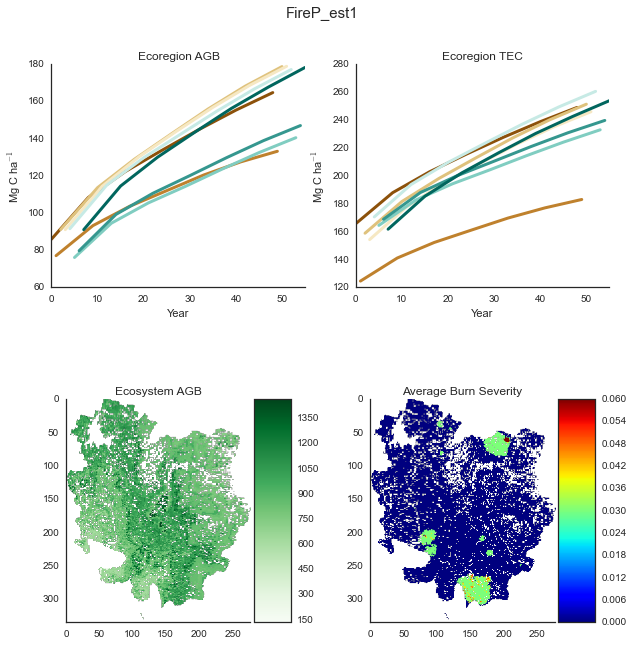

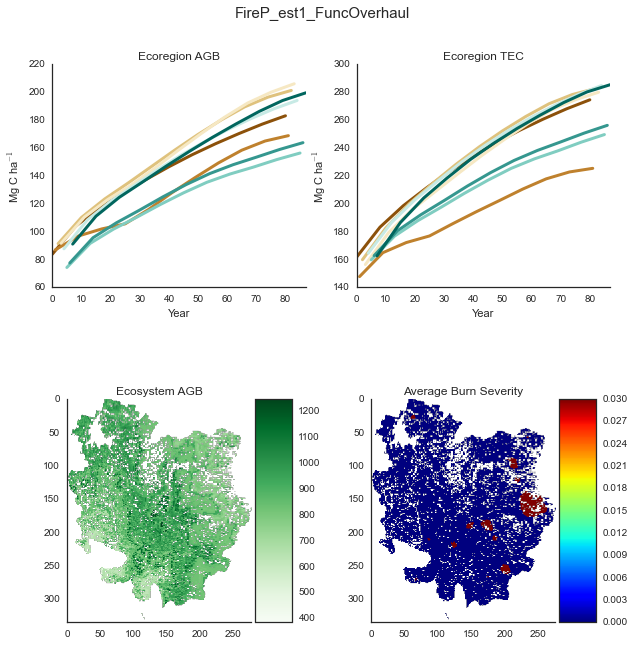

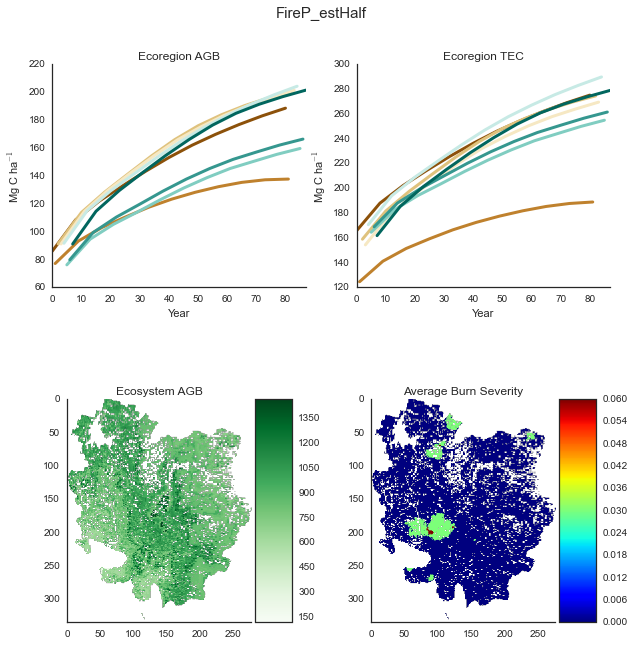

In [195]:
idx = 0
reps = [2]
simname = ['FireP_est1', 'FireP_est1_FuncOverhaul','FireP_estHalf']
for sim in simname:
    for rep in reps:
        wkDir = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/' + sim + '/output/DinkeyScenario/replicate' + str(rep) + '/fire/'
        wkDir_c = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/' + sim + '/output/DinkeyScenario/replicate' + str(rep) + '/'
        cent = pd.read_csv(wkDir_c + 'Century-succession-log.csv')
        cent_m = pd.read_csv(wkDir_c + 'Century-succession-monthly-log.csv')
        DFFS = pd.read_csv(wkDir + 'summary-log.csv')
        cent_g = cent.groupby(['EcoregionName', 'Time']).mean()

        
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (10, 10), dpi = 300)
        plt.subplots_adjust(hspace = 0.5, wspace = 0.2)
        axs = f.axes
        idx = 0
        for ecoregion in np.unique(cent.EcoregionName):
            eco = cent[cent.EcoregionName == ecoregion]
            ecoAGB = eco.AGB / 100 / 2 # Convert gram / m2 to Mg / ha -- then AGB to AGB (c)
            ecoAGB.plot(ax = axs[0], color = EcoregionFC[idx], lw = 3)
            idx = idx + 1
        axs[0].set_title('Ecoregion AGB')
        axs[0].set_xlabel('Year')
        axs[0].set_ylabel('Mg C ha$^{-1}$')
        sns.despine()
        idx = 0
        for ecoregion in np.unique(cent.EcoregionName):
            eco = cent[cent.EcoregionName == ecoregion]
            ecoAGB = eco.AGB / 100 / 2 # Convert gram / m2 to Mg / ha -- then AGB to AGB (c)
            ecoTEC = (eco.SOMTC / 100 / 2) + ecoAGB
            ecoTEC.plot(ax = axs[1], color = EcoregionFC[idx], lw = 3)
            idx = idx + 1
        axs[1].set_title('Ecoregion TEC')
        axs[1].set_xlabel('Year')
        axs[1].set_ylabel('Mg C ha$^{-1}$')
        sns.despine()


        timesteps = np.linspace(1, 70, 70)
        timesteps_cent = np.linspace(0,60,7)
        idx = 0
        base_map = np.zeros((335,277))
        for time in timesteps_cent:
            agbmap = wkDir_c + 'bioMAP/bio-TotalBiomass-' + str(int(time)) + '.img'
            src_ds = gdal.Open( agbmap )
            bioarray = src_ds.ReadAsArray()
            bioarray = bioarray.astype('float')
            bioarray[bioarray == 0] = np.nan
            masked_bio = np.ma.array (bioarray, mask=(np.isnan(bioarray)))
            base_map = base_map + masked_bio
            sns.set_style('white')
        ecoAGB = axs[2].imshow(base_map / 100 / 2, cmap = 'Greens')
        divider2 = make_axes_locatable(axs[2])
        cax2 = divider2.append_axes("right", size="20%", pad=0.05)
        plt.colorbar(ecoAGB, cax = cax2)
        axs[2].set_title('Ecosystem AGB')
        axx.set_label('AGB (MgC)', fontsize = 15)
        
        timesteps = np.linspace(1, 70, 70)
        timesteps_cent = np.linspace(0,70,8)

        base_map = np.zeros((335,277))
        for time in timesteps:   
            severitymap = wkDir + 'severity-' + str(int(time)) + '.img'
            src_ds = gdal.Open( severitymap )
            bioarray = src_ds.ReadAsArray()
            bioarray = bioarray.astype('float')
            bioarray[bioarray == 0] = np.nan
            bioarray[bioarray < 3] = 0
            masked_bio = np.ma.array (bioarray, mask=(np.isnan(bioarray)))
            base_map = base_map + masked_bio
            sns.set_style('white')
        divider3 = make_axes_locatable(axs[3])
        cax3 = divider3.append_axes("right", size="20%", pad=0.05)
        fireim = axs[3].imshow(base_map / 100, cmap = 'jet')
        plt.colorbar(fireim, cax = cax3)
        axs[3].set_title('Average Burn Severity')
        axx.set_label('Burned Area', fontsize = 15)
        plt.suptitle(sim, fontsize = 15)

        
        # Fire size from DFFS (hist by ecoregion)

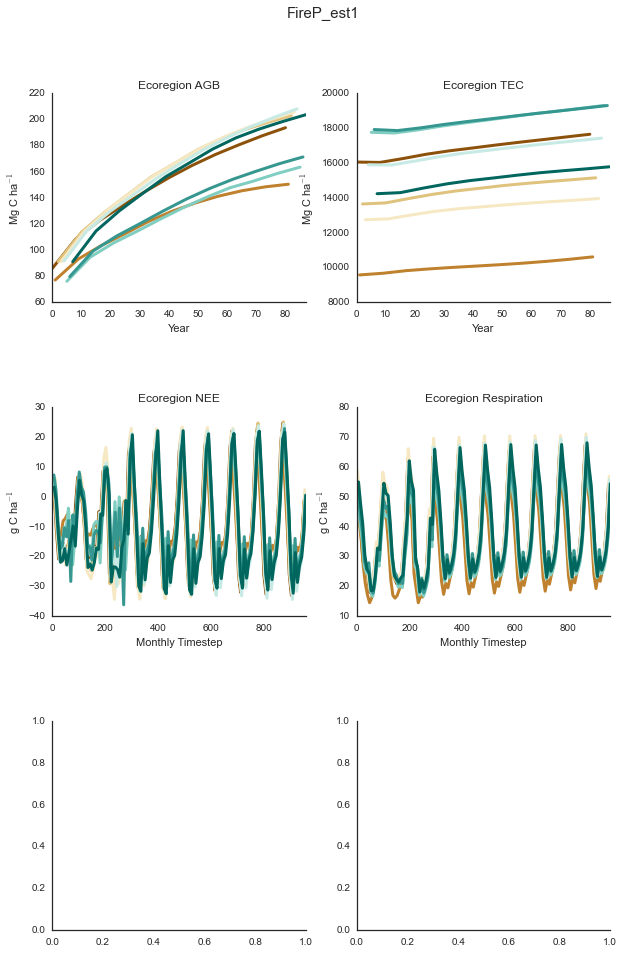

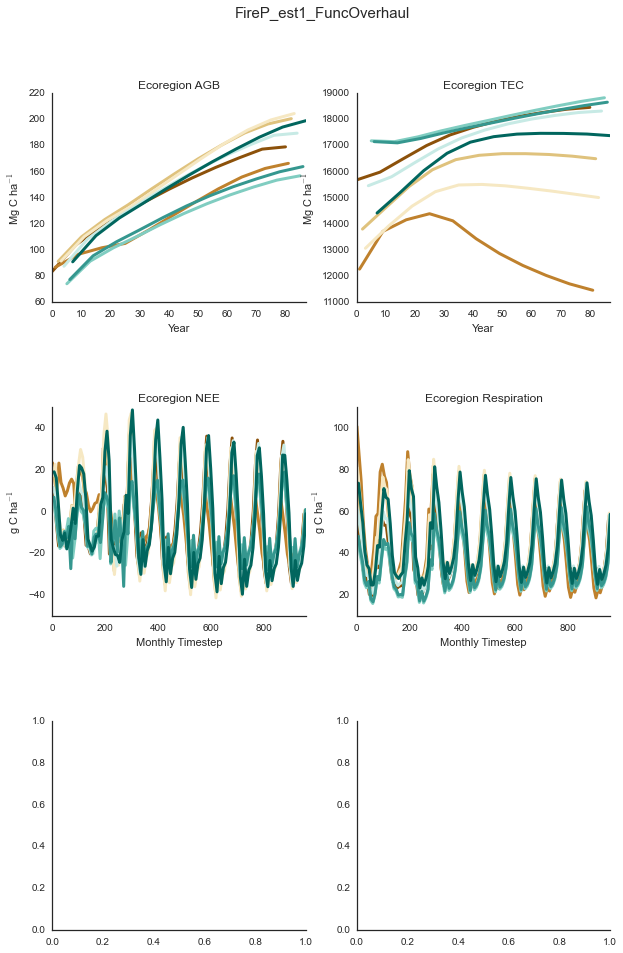

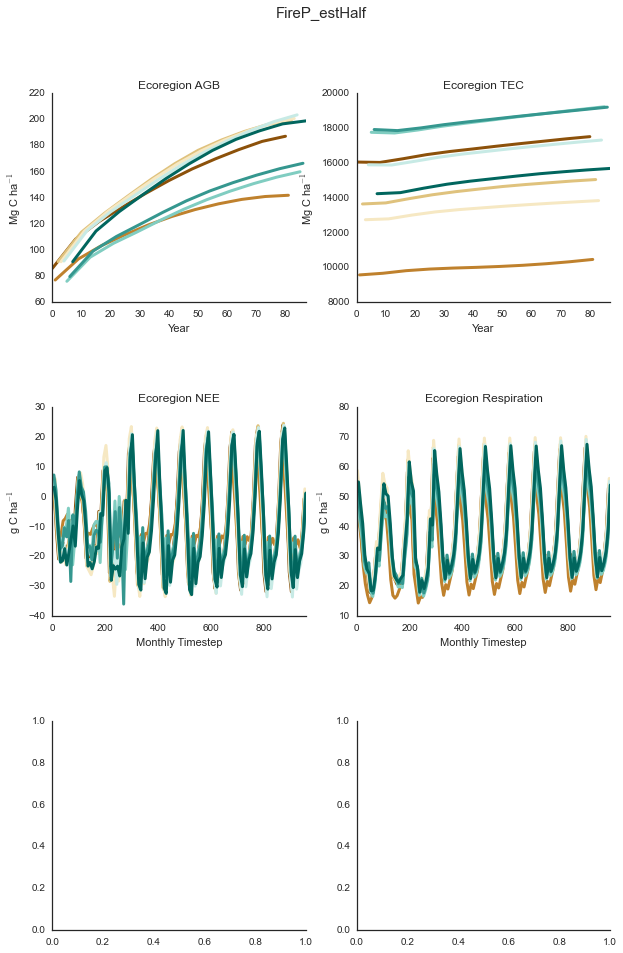

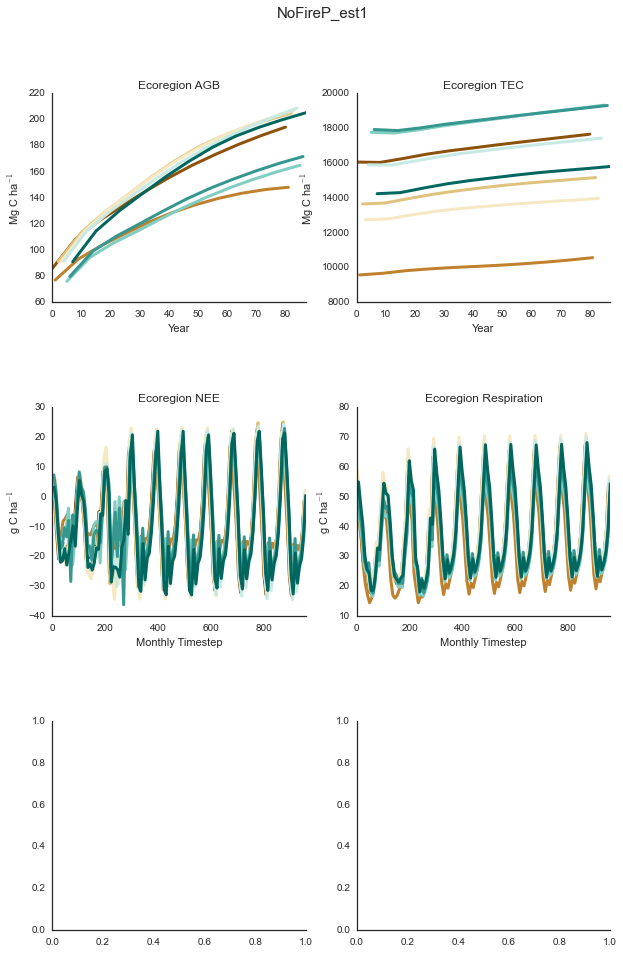

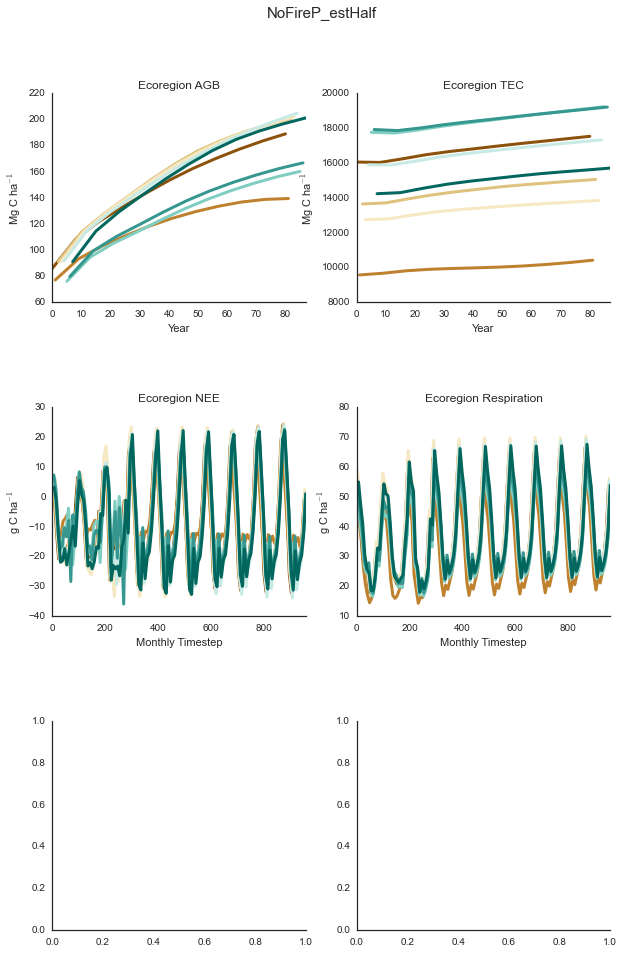

In [115]:
idx = 0
reps = [1]
simname = ['FireP_est1', 'FireP_est1_FuncOverhaul','FireP_estHalf', 'NoFireP_est1', 'NoFireP_estHalf']
for sim in simname:
    for rep in reps:
        wkDir = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/' + sim + '/output/DinkeyScenario/replicate' + str(rep) + '/fire/'
        wkDir_c = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/' + sim + '/output/DinkeyScenario/replicate' + str(rep) + '/'
        cent = pd.read_csv(wkDir_c + 'Century-succession-log.csv')
        cent_m = pd.read_csv(wkDir_c + 'Century-succession-monthly-log.csv')

        cent_g = cent.groupby(['EcoregionName', 'Time']).mean()

        
        f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize = (10, 15), dpi = 300)
        plt.subplots_adjust(hspace = 0.5, wspace = 0.2)
        axs = f.axes
        idx = 0
        for ecoregion in np.unique(cent.EcoregionName):
            eco = cent[cent.EcoregionName == ecoregion]
            ecoAGB = eco.AGB / 100 / 2 # Convert gram / m2 to Mg / ha -- then AGB to AGB (c)
            ecoAGB.plot(ax = axs[0], color = EcoregionFC[idx], lw = 3)
            idx = idx + 1
        axs[0].set_title('Ecoregion AGB')
        axs[0].set_xlabel('Year')
        axs[0].set_ylabel('Mg C ha$^{-1}$')
        sns.despine()
        idx = 0
        for ecoregion in np.unique(cent.EcoregionName):
            eco = cent[cent.EcoregionName == ecoregion]
            ecoAGB = eco.AGB / 100 / 2 # Convert gram / m2 to Mg / ha -- then AGB to AGB (c)
            ecoTEC = eco.SOMTC + ecoAGB
            ecoTEC.plot(ax = axs[1], color = EcoregionFC[idx], lw = 3)
            idx = idx + 1
        axs[1].set_title('Ecoregion TEC')
        axs[1].set_xlabel('Year')
        axs[1].set_ylabel('Mg C ha$^{-1}$')
        sns.despine()
        idx = 0
        for ecoregion in np.unique(cent_m.EcoregionName):
            eco = cent_m[cent_m.EcoregionName == ecoregion]
            eco.avgNEE.plot(ax = axs[2], color = EcoregionFC[idx], lw = 3)
            idx = idx + 1
        axs[2].set_title('Ecoregion NEE')
        axs[2].set_xlabel('Monthly Timestep')
        axs[2].set_ylabel('g C ha$^{-1}$')
        sns.despine()
        idx = 0
        for ecoregion in np.unique(cent_m.EcoregionName):
            eco = cent_m[cent_m.EcoregionName == ecoregion]
            eco.avgResp.plot(ax = axs[3], color = EcoregionFC[idx], lw = 3)
            idx = idx + 1
        axs[3].set_title('Ecoregion Respiration')
        axs[3].set_xlabel('Monthly Timestep')
        axs[3].set_ylabel('g C ha$^{-1}$')
        sns.despine()
        plt.suptitle(sim, fontsize = 15)



        

        


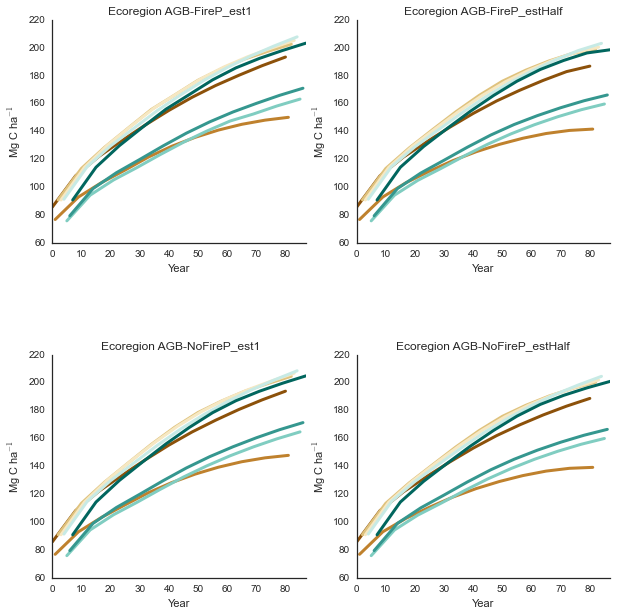

In [130]:

reps = [1]
idxa = 0
counter = 0
simname =  ['FireP_est1','FireP_estHalf', 'NoFireP_est1', 'NoFireP_estHalf']
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (10, 10), dpi = 300)
plt.subplots_adjust(hspace = 0.5, wspace = 0.2)
axs = f.axes
for sim in simname:
    for rep in reps:
        wkDir = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/' + sim + '/output/DinkeyScenario/replicate' + str(rep) + '/fire/'
        wkDir_c = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/' + sim + '/output/DinkeyScenario/replicate' + str(rep) + '/'
        cent = pd.read_csv(wkDir_c + 'Century-succession-log.csv')
        cent_m = pd.read_csv(wkDir_c + 'Century-succession-monthly-log.csv')
        cent_g = cent.groupby(['EcoregionName', 'Time']).mean()
        cent['SIM'] = sim
        if counter == 0:
            totalCent = cent
        else:
            totalCent = pd.concat((totalCent, cent))
        idx = 0
       
        ax = axs[idxa]
        for ecoregion in np.unique(cent.EcoregionName):
            eco = cent[cent.EcoregionName == ecoregion]
            ecoAGB = eco.AGB / 100 / 2 # Convert gram / m2 to Mg / ha -- then AGB to AGB (c)
            ecoAGB.plot(ax = ax, color = EcoregionFC[idx], lw = 3)
            idx = idx + 1
        ax.set_title('Ecoregion AGB' + '-' + sim)
        ax.set_xlabel('Year')
        ax.set_ylabel('Mg C ha$^{-1}$')
        sns.despine()
        idxa = idxa + 1
        counter = counter + 1
